In [1]:
import tensorflow as tf
import numpy as np
from functools import partial
from sklearn.preprocessing import StandardScaler

height, width, n_channels = (28, 28, 1)

conv_layer = partial(tf.keras.layers.Conv2D,
                     kernel_size=(3,3),
                     padding='same',
                     activation='elu')
maxpooling_layer = partial(tf.keras.layers.MaxPool2D,
                           pool_size=(2,2),
                           strides=(2,2),
                           padding='same')

model = tf.keras.models.Sequential()

model.add(conv_layer(filters=32,
                     input_shape=(height, width, n_channels),
                     name='encoder_conv1'))
model.add(maxpooling_layer(name='encoder_maxpooling1'))
model.add(conv_layer(filters=32, name='encoder_conv2'))
model.add(maxpooling_layer(name='encoder_maxpooling2'))

model.add(conv_layer(filters=32, name='decoder_conv1'))
model.add(tf.keras.layers.UpSampling2D(size=(2,2), name='decoder_upsampling1'))
model.add(conv_layer(filters=32, name='decoder_conv2'))
model.add(tf.keras.layers.UpSampling2D(size=(2,2), name='decoder_upsampling2'))
model.add(conv_layer(filters=1, name='decoder_conv3'))

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

W0908 18:06:40.274355 140600415614784 deprecation.py:506] From /home/guhwanbae/anaconda3/envs/gu-keras/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(len(y_train), -1).astype(np.float32)
X_test = X_test.reshape(len(y_test), -1).astype(np.float32)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).reshape(-1, height, width, n_channels)
X_test = scaler.transform(X_test).reshape(-1, height, width, n_channels)

In [3]:
def add_gaussian_noise(X, noise_level=0.5):
    return X + noise_level * np.random.normal(size=X.shape)

X_train_noisy = add_gaussian_noise(X_train)
X_test_noisy = add_gaussian_noise(X_test)

In [4]:
model_path = './gaussian_denoisor_with_cnn.h5'
model_saver = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=0, save_best_only=True)
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)

n_epochs = 50
batch_size = 1024

model.fit(x=X_train_noisy, y=X_train,
          epochs=n_epochs, batch_size=batch_size,
          shuffle=True, validation_data=(X_test_noisy, X_test),
          callbacks=[model_saver, early_stopper])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 132us/sample - loss: 0.4705 - mean_absolute_error: 0.3328 - val_loss: 0.3625 - val_mean_absolute_error: 0.2855
Epoch 2/50
60000/60000 [==============================] - 6s 101us/sample - loss: 0.3188 - mean_absolute_error: 0.2774 - val_loss: 0.2773 - val_mean_absolute_error: 0.2657
Epoch 3/50
60000/60000 [==============================] - 6s 101us/sample - loss: 0.2470 - mean_absolute_error: 0.2594 - val_loss: 0.2209 - val_mean_absolute_error: 0.2489
Epoch 4/50
60000/60000 [==============================] - 6s 102us/sample - loss: 0.2032 - mean_absolute_error: 0.2479 - val_loss: 0.1900 - val_mean_absolute_error: 0.2409
Epoch 5/50
60000/60000 [==============================] - 6s 101us/sample - loss: 0.1781 - mean_absolute_error: 0.2389 - val_loss: 0.1710 - val_mean_absolute_error: 0.2323
Epoch 6/50
60000/60000 [==============================] - 6s 103us/sample - loss: 0.1617 -

60000/60000 [==============================] - 6s 100us/sample - loss: 0.0697 - mean_absolute_error: 0.1429 - val_loss: 0.0726 - val_mean_absolute_error: 0.1411
Epoch 49/50
60000/60000 [==============================] - 6s 101us/sample - loss: 0.0695 - mean_absolute_error: 0.1425 - val_loss: 0.0732 - val_mean_absolute_error: 0.1406
Epoch 50/50
60000/60000 [==============================] - 6s 102us/sample - loss: 0.0690 - mean_absolute_error: 0.1417 - val_loss: 0.0720 - val_mean_absolute_error: 0.1419


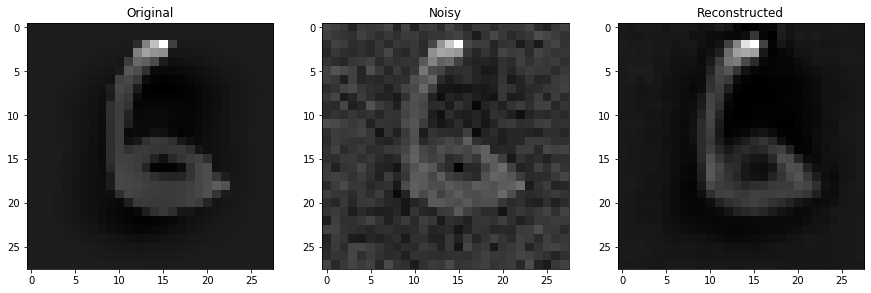

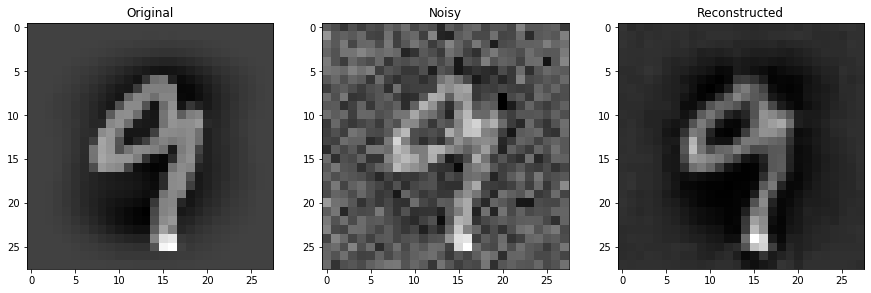

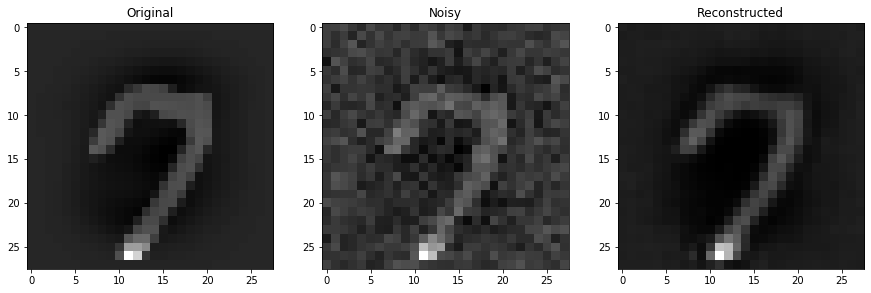

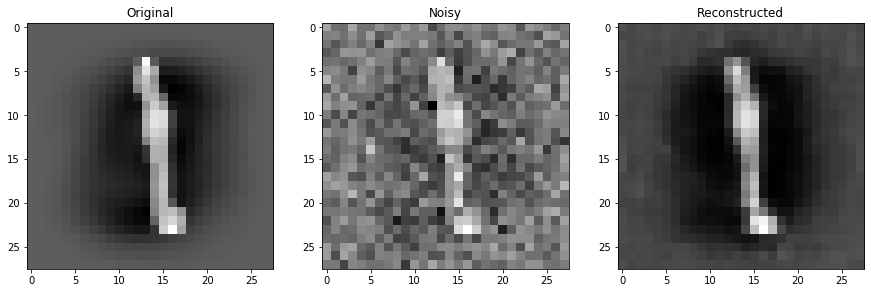

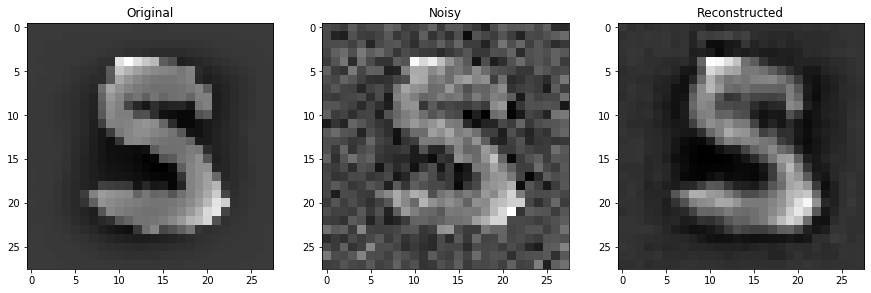

In [6]:
import matplotlib.pyplot as plt

reconstructions = model.predict(X_test_noisy)

for rand_idx in np.random.randint(0, len(X_test_noisy)-1, 5):
    plt.figure(figsize=(15,9))
    plt.gray()
    
    plt.subplot(131)
    plt.title('Original')
    plt.imshow(X_test[rand_idx].reshape(28,28))
    
    plt.subplot(132)
    plt.title('Noisy')
    plt.imshow(X_test_noisy[rand_idx].reshape(28,28))
    
    plt.subplot(133)
    plt.title('Reconstructed')
    plt.imshow(reconstructions[rand_idx].reshape(28,28))
    plt.show()